# Front-Door Criterion - Smoking and Lung Cancer

## 1. Install and Import required libraries

In [1]:
!pip install dowhy pandas matplotlib pydot graphviz

import pandas as pd
from dowhy import CausalModel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.2/399.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 23.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.6.7
    Uninstalling cvxpy-1.6.7:
      Successfully uninstalled cvxpy-1.6.7


## 2. Create dataset

The dataset contains information on smoking status (X), presence of tar deposits in the lungs (Z), and lung cancer outcome (Y) for 800 individuals. The smoker group and non-smoker group are of equal size (400 each). All variables are binary, where 1 indicates presence/yes and 0 indicates absence/no.

| X (Smoker) | Z (Tar deposits) | Y (Cancer) | Count |
| ---------- | ---------------- | ---------- | ----- |
| 1 (Yes)    | 1 (Yes)          | 0 (No)     | 323   |
| 1 (Yes)    | 1 (Yes)          | 1 (Yes)    | 57    |
| 1 (Yes)    | 0 (No)           | 0 (No)     | 18    |
| 1 (Yes)    | 0 (No)           | 1 (Yes)    | 2     |
| 0 (No)     | 1 (Yes)          | 0 (No)     | 1     |
| 0 (No)     | 1 (Yes)          | 1 (Yes)    | 19    |
| 0 (No)     | 0 (No)           | 0 (No)     | 38    |
| 0 (No)     | 0 (No)           | 1 (Yes)    | 342   |


In [2]:
# Smoker group (400 total)
data = []
data += [{'X':'yes','Z':'yes','Y':'no'}]*323
data += [{'X':'yes','Z':'yes','Y':'yes'}]*57
data += [{'X':'yes','Z':'no','Y':'no'}]*18
data += [{'X':'yes','Z':'no','Y':'yes'}]*2

# Nonsmoker group (400 total)
data += [{'X':'no','Z':'yes','Y':'no'}]*1
data += [{'X':'no','Z':'yes','Y':'yes'}]*19
data += [{'X':'no','Z':'no','Y':'no'}]*38
data += [{'X':'no','Z':'no','Y':'yes'}]*342

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert categorical values to numeric (0/1)
df['X'] = df['X'].map({'yes':1, 'no':0})   # Smoker = 1, Non-smoker = 0
df['Z'] = df['Z'].map({'yes':1, 'no':0})   # Tar deposits = 1, No tar = 0
df['Y'] = df['Y'].map({'yes':1, 'no':0})   # Cancer = 1, No cancer = 0
print("Dataset preview:")
print(df.head())

Dataset preview:
   X  Z  Y
0  1  1  0
1  1  1  0
2  1  1  0
3  1  1  0
4  1  1  0


In [14]:
# Cancer rates by smoking status
smoker_cancer_rate = df[df['X'] == 1]['Y'].mean()
nonsmoker_cancer_rate = df[df['X'] == 0]['Y'].mean()
risk_difference = smoker_cancer_rate - nonsmoker_cancer_rate
relative_risk = smoker_cancer_rate / nonsmoker_cancer_rate

print(f"Cancer rate among smokers: {smoker_cancer_rate:.3f} ({smoker_cancer_rate*100:.1f}%)")
print(f"Cancer rate among non-smokers: {nonsmoker_cancer_rate:.3f} ({nonsmoker_cancer_rate*100:.1f}%)")
print(f"Risk difference (naive): {risk_difference:.3f}")
print(f"Relative risk (naive): {relative_risk:.2f}")

# Tar deposit rates
tar_smokers = df[df['X'] == 1]['Z'].mean()
tar_nonsmokers = df[df['X'] == 0]['Z'].mean()
print(f"\nTar deposit rate among smokers: {tar_smokers:.3f} ({tar_smokers*100:.1f}%)")
print(f"Tar deposit rate among non-smokers: {tar_nonsmokers:.3f} ({tar_nonsmokers*100:.1f}%)")

Cancer rate among smokers: 0.147 (14.8%)
Cancer rate among non-smokers: 0.902 (90.2%)
Risk difference (naive): -0.755
Relative risk (naive): 0.16

Tar deposit rate among smokers: 0.950 (95.0%)
Tar deposit rate among non-smokers: 0.050 (5.0%)


## 3. Define the causal graph

Graph structure :
- X (smoking) causes Z (tar deposits)
- Z causes Y (lung cancer)
- U is an unobserved confounder that affects both X and Y

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
/usr/local/lib/python3.12/dist-packages/dowhy/causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


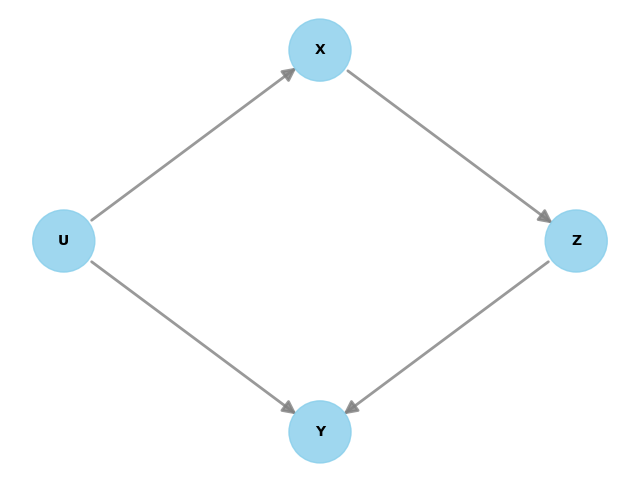

In [3]:
causal_graph = """
digraph {
    X -> Z;
    Z -> Y;
    U[label="Unobserved Confounder", shape=ellipse];
    U -> X;
    U -> Y;
}
"""

# Create DoWhy CausalModel
model = CausalModel(
    data=df,
    treatment="X",
    outcome="Y",
    common_causes=["U"],
    graph=causal_graph
)

# Visualize the model (optional, requires pydot/graphviz installed)
model.view_model()

## 4. Identify the causal effect

Here we identify the causal effect, either by means of the backdoor criterion, or by means of instrumental variables (iv), or by means of the frontdoor criterion, or by means of a general adjustment.

In [4]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("Identified Estimand:")
print(identified_estimand)

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)

### Estimand : 4
Estimand name: general_adjustment
No such variable(s) found!



**Front Door Path**: The causal effect flows through X → Z → Y, where Z (tar deposits) is the mediator.

**Identification**: The front door criterion works because:

- Z intercepts all directed paths from X to Y

- There is no unblocked backdoor path from X to Z

- All backdoor paths from Z to Y are blocked by X

**Interpretation:** The front door estimate will account for the unobserved confounder U that affects both smoking (X) and cancer (Y).

**Two-Stage Regression**: `DoWhy` uses a two-stage regression approach for the front door criterion:

*Stage 1*: Regress Z on X to get P(Z|X)

*Stage 2*: Regress Y on Z and X to get P(Y|Z,X)

Combine these to estimate the causal effect



In [5]:
# Estimate using front-door
estimate = model.estimate_effect(
    identified_estimand,
    method_name="frontdoor.two_stage_regression"
)
print("Estimated causal effect:", estimate)

Estimated causal effect: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)

## Realized estimand
(b: Z~X)*(b: Y~Z+X)
Target units: ate

## Estimate
Mean value: 0.0449999999999995



/usr/local/lib/python3.12/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.12/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


This output shows the _causal effect_ of smoking (X) on lung cancer (Y) using the front-door criterion with tar deposits (Z) as the mediator. The estimated average treatment effect (ATE) is 0.045, meaning smoking increases the probability of lung cancer by about 4.5 percentage points after accounting for unobserved confounders.

The front-door method works by measuring how smoking affects tar deposits, and then how tar deposits affect cancer risk, while satisfying three key assumptions: full mediation (all effect goes through tar), no confounding between smoking and tar, and no confounding between tar and cancer beyond what's explained by smoking.

This 4.5% effect is likely smaller than the naive observed difference because the front-door criterion properly adjusts for unobserved confounders that affect both smoking behavior and cancer risk.

